In [ ]:

from torch.utils.data import Dataset
from PIL import Image
import os
import glob
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class CustomBreastCancerDataset(Dataset):
    def __init__(self, root_dir="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT", train=True, transform=None):
        self.categories = ["benign", "malignant", "normal"]
        self.transform = transform
        self.images = []
        self.labels = []

        # Load image paths and labels
        for idx, category in enumerate(self.categories):
            cat_path = os.path.join(root_dir, category)
            image_files = glob.glob(os.path.join(cat_path, "*_mask.*"))  # Adjust extension if needed
            self.images.extend(image_files)
            self.labels.extend([idx] * len(image_files))

        # Train-validation split
        self.train_images, self.val_images, self.train_labels, self.val_labels = train_test_split(
            self.images, self.labels, test_size=0.2, random_state=42, stratify=self.labels
        )
        if train:
            self.images, self.labels = self.train_images, self.train_labels
        else:
            self.images, self.labels = self.val_images, self.val_labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [3]:
# Instantiate and test the dataset
try:
    dataset = CustomBreastCancerDataset(train=True)
    print(f"Dataset Size: {len(dataset)}")
    img_sample, label_sample = dataset[100]
    print(f"Sample Image Dimensions: {img_sample.size}")
    print(f"Label: {dataset.categories[label_sample]}")
except ValueError as e:
    print(f"Error encountered: {e}\nCheck if dataset paths are correct and data is loaded.")

Dataset Size: 624
Sample Image Dimensions: (557, 457)
Label: malignant


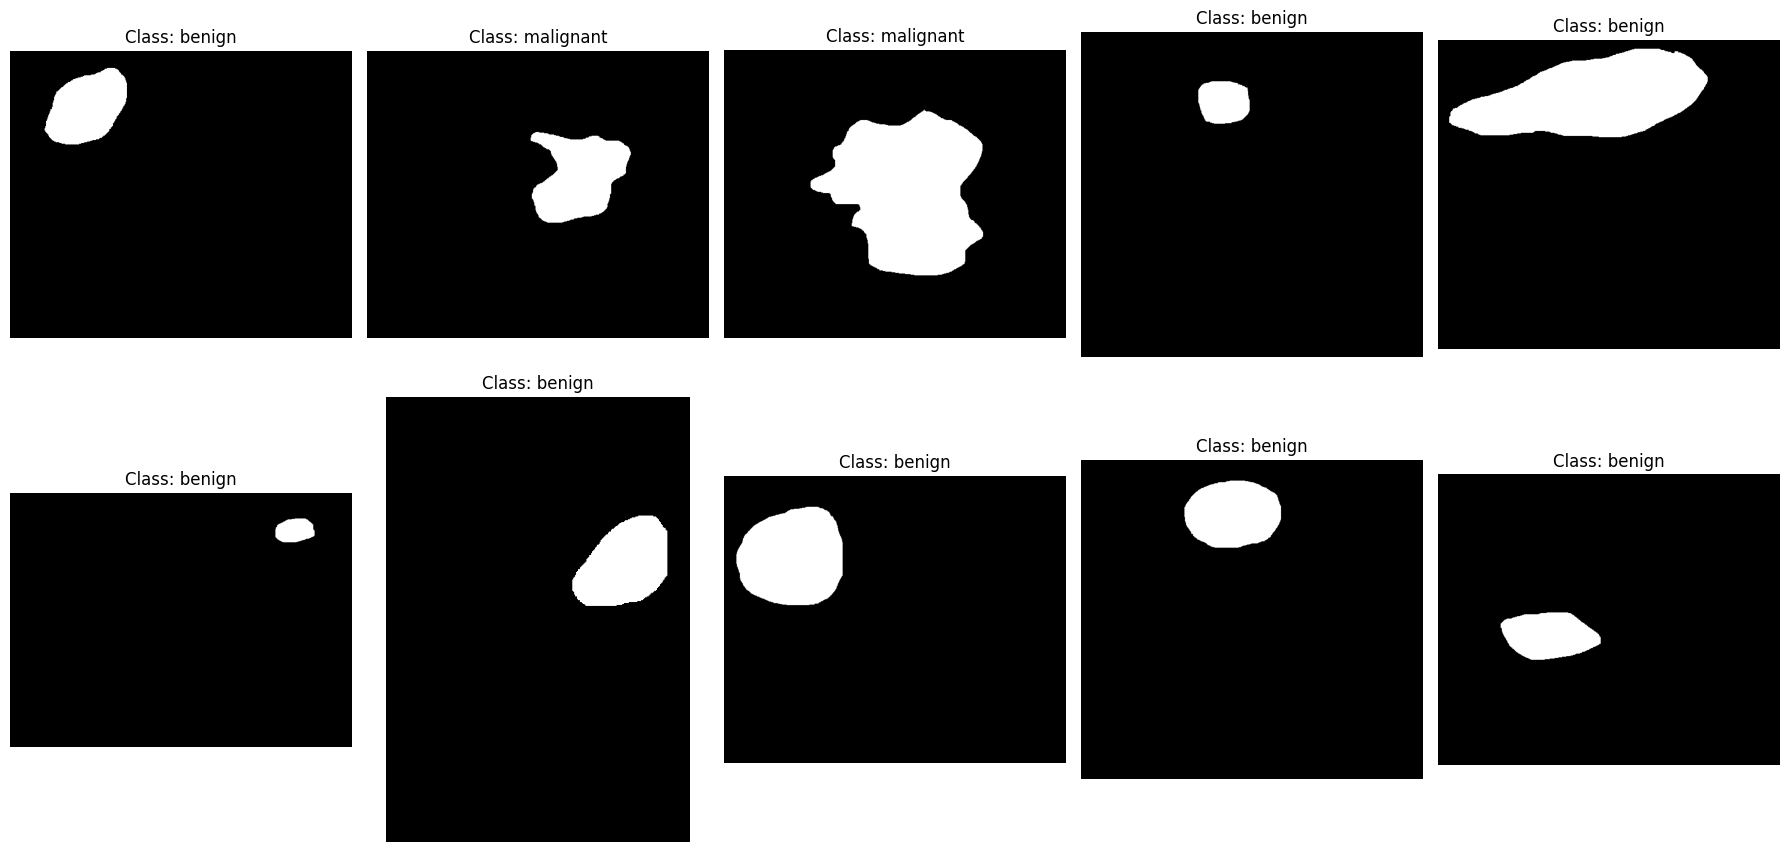

In [4]:
# Function to display a subset of images randomly chosen from the dataset
def visualize_random_samples(dataset, total_images=10):
    plt.figure(figsize=(18, 9))
    
    for idx in range(total_images):
        # Select a random index
        random_index = random.choice(range(len(dataset)))
        image, label = dataset[random_index]
        
        # Convert PIL image to numpy array for better display handling
        if isinstance(image, Image.Image):
            image = np.array(image)
        
        # Set up a subplot to display the image
        plt.subplot(2, 5, idx + 1)
        plt.imshow(image)
        plt.title(f'Class: {dataset.categories[label]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Initialize the dataset
dataset = CustomBreastCancerDataset()

# Show random images
visualize_random_samples(dataset)


TRAINING MODEL

In [5]:
# Importing necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import shutil
import os
import random
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Data transformations for augmentation
def transform_imgs(image_size=224):
    train_transform = transforms.Compose([
        transforms.RandomAffine(degrees=(-5, 5), translate=(0.15, 0.15), scale=(0.85, 1.15), shear=10),
        transforms.ColorJitter(brightness=0.125, contrast=0.5, saturation=0.5, hue=0.05),
        transforms.ToTensor(),
        transforms.Resize((image_size, image_size)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((image_size, image_size)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return train_transform, valid_transform


In [7]:
# Training function
def train(model, train_dataloader, epoch, epochs, writer, criterion, optimizer, device):
    model.train()
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{epochs}", colour="cyan")

    for iteration, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Logging
        writer.add_scalar("Loss/train", loss.item(), epoch * len(train_dataloader) + iteration)
        progress_bar.set_postfix(loss=loss.item())

In [8]:
# Validation function
def valid(model, valid_dataloader, criterion, device):
    model.eval()
    all_losses, all_labels, all_predictions = [], [], []

    with torch.no_grad():
        for images, labels in valid_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            predictions = torch.argmax(output, dim=1)

            all_losses.append(loss.item())
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Metrics
    avg_loss = np.mean(all_losses)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return avg_loss, accuracy, f1

In [9]:
# Main function to setup and train the model
def main():
    # Hyperparameters and paths
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 32
    image_size = 224
    epochs = 7
    lr = 1e-5
    data_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
    log_path = "tensorboard"
    checkpoint_path = "trained_models"

    # Model setup
    model = models.resnet50(weights='IMAGENET1K_V2')
    model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust for 3 classes
    model.to(device)

    # Dataset and DataLoader
    train_transform, valid_transform = transform_imgs(image_size)
    
    train_dataset = CustomBreastCancerDataset(root_dir=data_path, transform=train_transform, train=True)
    valid_dataset = CustomBreastCancerDataset(root_dir=data_path, transform=valid_transform, train=False)



    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Logging setup
    if os.path.exists(log_path):
        shutil.rmtree(log_path)
    os.makedirs(log_path)
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    
    writer = SummaryWriter(log_path)

    # Training loop
    best_acc = 0
    for epoch in range(epochs):
        train(model, train_dataloader, epoch, epochs, writer, criterion, optimizer, device)
        
        # Validation
        val_loss, val_accuracy, val_f1 = valid(model, valid_dataloader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")
        
        # Tensorboard logging
        writer.add_scalar("Validation/Loss", val_loss, epoch)
        writer.add_scalar("Validation/Accuracy", val_accuracy, epoch)
        
        # Save checkpoints
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "epoch": epoch,
            "optimizer_state_dict": optimizer.state_dict()
        }
        torch.save(checkpoint, os.path.join(checkpoint_path, f"epoch_{epoch+1}.pt"))
        
        if val_accuracy > best_acc:
            torch.save(checkpoint, os.path.join(checkpoint_path, "best_model.pt"))
            best_acc = val_accuracy


In [10]:
if __name__ == '__main__':
    main()
    pass

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s] 
Training Epoch 1/7: 100%|██████████| 20/20 [03:19<00:00,  9.99s/it, loss=1.05] 


Epoch 1/7 | Loss: 1.0733 | Accuracy: 0.6090 | F1 Score: 0.5549


Training Epoch 2/7: 100%|██████████| 20/20 [03:11<00:00,  9.57s/it, loss=0.837]


Epoch 2/7 | Loss: 0.9813 | Accuracy: 0.8462 | F1 Score: 0.8428


Training Epoch 3/7: 100%|██████████| 20/20 [03:26<00:00, 10.31s/it, loss=0.64] 


Epoch 3/7 | Loss: 0.8471 | Accuracy: 0.7436 | F1 Score: 0.6740


Training Epoch 4/7: 100%|██████████| 20/20 [03:13<00:00,  9.66s/it, loss=0.569]


Epoch 4/7 | Loss: 0.6143 | Accuracy: 0.9487 | F1 Score: 0.9487


Training Epoch 5/7: 100%|██████████| 20/20 [03:15<00:00,  9.76s/it, loss=0.458]


Epoch 5/7 | Loss: 0.4331 | Accuracy: 0.9744 | F1 Score: 0.9745


Training Epoch 6/7: 100%|██████████| 20/20 [03:13<00:00,  9.70s/it, loss=0.239]


Epoch 6/7 | Loss: 0.3360 | Accuracy: 0.8141 | F1 Score: 0.7400


Training Epoch 7/7: 100%|██████████| 20/20 [03:13<00:00,  9.70s/it, loss=0.285]


Epoch 7/7 | Loss: 0.1576 | Accuracy: 0.9936 | F1 Score: 0.9936


In [21]:
import torch
import os

epoch = 7 
model = models.resnet50(weights='IMAGENET1K_V2')
optimizer = torch.optim.Adam(model.parameters())

# Ensure the directory exists
os.makedirs('trained_models', exist_ok=True)

# Save the model checkpoint
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'trained_models/best_model.pth')


INFERENCE

In [23]:
# 3.1) Define UnNormalize class
from torchvision import transforms

class ReverseNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

reverse_norm = ReverseNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [25]:
from torchvision.models import resnet50

def load_trained_model(path, device):
    model = resnet50(pretrained=False)
    
    model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=3)  # Set the number of classes
    model.to(device)
    
    checkpoint = torch.load(os.path.join(path, "best_model.pth"), map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    return model.to(device)

In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt

def display_predictions(model, dataset, resize, class_names, device, reverse_norm, num_images=10):
    plt.figure(figsize=(20, 10))
    
    for i in range(num_images):
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]
        
        image_tensor = resize(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            probs = torch.softmax(output, dim=1)
            pred_prob, pred_class = torch.max(probs, dim=1)
            
        score = pred_prob.item() * 100
        predicted_label = class_names[pred_class.item()]
        true_label = class_names[label]
        
        image = reverse_norm(image)
        image = np.array(image).transpose(1, 2, 0)
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_label} | Actual: {true_label}")
        plt.axis('off')
    
    plt.show()